In [2]:
import sys
import tyssue
import random
import numpy as np
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
import ipyvolume as ipv
from matplotlib import pyplot
from tyssue.solvers import QSSolver

from IPython.display import Image


from tyssue.topology import add_vert


from tyssue import config, Sheet, SheetGeometry, History, EventManager, PlanarGeometry
from tyssue import SheetGeometry as geom
from tyssue import PlanarGeometry as geom
from tyssue.draw.plt_draw import create_gif
from tyssue.draw.plt_draw import plot_forces
from tyssue.draw import sheet_view
from tyssue.dynamics import effectors, model_factory
from tyssue.dynamics import PlanarModel
from tyssue.dynamics import SheetModel as model
from tyssue.generation import three_faces_sheet
from tyssue.solvers.viscous import EulerSolver
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
from tyssue.draw.plt_draw import plot_forces
from tyssue.io import hdf5
import copy

from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model


from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division

import warnings
warnings.filterwarnings('ignore')

### T1 transitions

from tyssue.topology.sheet_topology import type1_transition
from tyssue.topology.base_topology import collapse_edge, remove_face
from tyssue.topology.sheet_topology import split_vert as sheet_split
from tyssue.topology.bulk_topology import split_vert as bulk_split
from tyssue.topology import condition_4i, condition_4ii

ModuleNotFoundError: No module named 'tyssue.solvers'

In [2]:
def length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity):
    
    cellmap.edge_df['length_elasticity_ECM'] = cellmap.edge_df['length_elasticity']
    cellmap.edge_df['length_elasticity_FRC'] = cellmap.edge_df['length_elasticity']
        
    for edge in range(len(cellmap.edge_df)):
        FRC = random.randrange(FRC_lower_length_elasticity, FRC_higher_length_elasticity)/10000
        ECM = random.randrange(ECM_lower_length_elasticity, ECM_higher_length_elasticity)/10000
        cellmap.edge_df['length_elasticity'][edge] = FRC + ECM
        cellmap.edge_df['length_elasticity_ECM'][edge] = ECM
        cellmap.edge_df['length_elasticity_FRC'][edge] = FRC
    return cellmap

In [3]:
def prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area):
    for face in range(len(cellmap.face_df)):
        newValue = random.randrange(lower_prefered_area, higher_prefered_area)/10000
        cellmap.face_df['prefered_area'][face] = newValue
    return cellmap

In [4]:
def change_specs(cellmap, geom, model, history, area_elasticity,
                 lower_prefered_area, higher_prefered_area, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity,
                 ECM_higher_length_elasticity, line_nought):
    
    
    length_elasticity_range(cellmap, FRC_lower_length_elasticity, FRC_higher_length_elasticity, ECM_lower_length_elasticity, ECM_higher_length_elasticity)
    prefered_area_range(cellmap, lower_prefered_area, higher_prefered_area)
    
    cellmap.face_df["area_elasticity"] = area_elasticity
    cellmap.edge_df["prefered_length"] = line_nought


    cellmap.vert_df["viscosity"] = 1   
    
    #cellmap_original.face_df["prefered_area"][0] = 2
    #cellmap_original.face_df["prefered_area"][41] = 2

    
    solver = QSSolver()
    res = solver.find_energy_min(cellmap, geom, model)

    fig, ax = sheet_view(cellmap, mode="quick")
    fig.set_size_inches(10, 10)
    

        

    
    cellmap_new = copy.deepcopy(cellmap_original)
    geom_new = copy.deepcopy(geom_original)
    model_new = copy.deepcopy(model_original)
    history_new = copy.deepcopy(history_original)
    
    return [cellmap_new, geom_new, model_new, history_new]

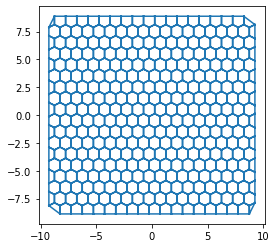

In [8]:
## Definition of the sheet

cellmap_original = Sheet.planar_sheet_2d('cellmap', 20, 20, 1, 1) # This may need to change
geom_original  = PlanarGeometry

to_cut = cellmap_original.cut_out([(-2, 10), (-2, 10)])
#cellmap_original.remove(to_cut, trim_borders=True)
cellmap_original.sanitize(trim_borders=True)
geom.center(cellmap_original)
geom.update_all(cellmap_original)
cellmap_original.update_rank()

model_original = model_factory([    
    effectors.FaceAreaElasticity,
    effectors.LengthElasticity
    ])

history_original = History(cellmap_original,
                           extra_cols={"edge":["dx", "dy"]})

cellmap_original.update_specs(model_original.specs)

fig, ax = sheet_view(cellmap_original, ['x', 'y'], mode='quick')

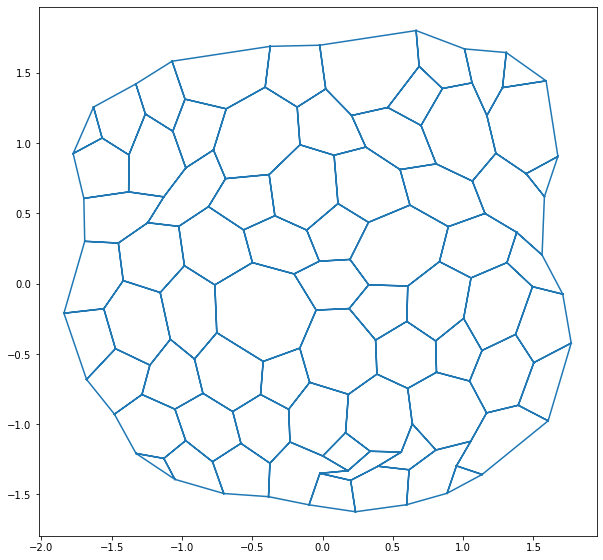

In [33]:
[cellmap_H, geom_H, model_H, history_H] = change_specs(cellmap_original, geom_original, model_original, history_original, area_elasticity = 0.5, lower_prefered_area = 1000, higher_prefered_area = 10000, 
                                                       FRC_lower_length_elasticity = 1000, FRC_higher_length_elasticity = 10000, ECM_lower_length_elasticity = 100, 
                                                       ECM_higher_length_elasticity = 1000, line_nought = 0.2)

In [34]:
cellmap_original.edge_df

,trgt,nz,length,face,srce,dx,dy,sx,sy,tx,...,is_valid,rx,ry,sub_area,is_active,length_elasticity,prefered_length,uz,length_elasticity_ECM,length_elasticity_FRC
edge,,,,,,,,,,,,,,,,,,,,,
0,7,0.056342,0.298067,67,6,-0.296943,0.025852,1.307235,1.643748,1.010291,...,True,0.141036,0.177460,0.028171,1,0.9220,0.2,0.57735,0.0615,0.8605
1,8,0.094595,0.313720,59,0,-0.310029,-0.047980,1.590479,1.442318,1.280450,...,True,0.191031,0.334681,0.047298,1,0.2057,0.2,0.57735,0.0159,0.1898
2,0,0.025346,0.313720,68,8,0.310029,0.047980,1.280450,1.394338,1.590479,...,True,-0.112271,-0.099130,0.012673,1,0.3255,0.2,0.57735,0.0304,0.2951
3,8,0.025346,0.250845,68,6,-0.026785,-0.249410,1.307235,1.643748,1.280450,...,True,-0.085486,0.150280,0.012673,1,0.3683,0.2,0.57735,0.0501,0.3182
4,6,0.030422,0.250845,67,8,0.026785,0.249410,1.280450,1.394338,1.307235,...,True,0.114251,-0.071950,0.015211,1,0.5031,0.2,0.57735,0.0363,0.4668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,54,0.185917,0.693929,65,10,-0.686044,-0.104315,0.665647,1.800186,-0.020396,...,True,0.328040,0.320878,0.092958,1,0.2444,0.2,0.57735,0.0750,0.1694
380,49,0.008905,0.332421,1,91,0.276546,-0.184462,-1.327060,-1.208245,-1.050514,...,True,-0.158174,0.073304,0.004453,1,0.7405,0.2,0.57735,0.0616,0.6789
381,92,0.060471,0.317290,18,51,0.198520,-0.247513,-1.679046,-0.681615,-1.480526,...,True,-0.249886,0.006945,0.030236,1,0.6994,0.2,0.57735,0.0666,0.6328


In [35]:
cellmap_original.face_df

,y,is_alive,perimeter,area,x,num_sides,id,area_elasticity,prefered_area
face,,,,,,,,,
0,-1.486769,1,1.021345,0.062485,0.079875,4,0,0.5,0.6116
1,-1.281549,1,0.702002,0.013358,-1.168885,3,0,0.5,0.1625
2,-1.302801,1,1.214162,0.083986,-0.927743,5,0,0.5,0.1360
3,-1.338207,1,1.287843,0.111488,-0.564925,5,0,0.5,0.6004
4,-1.343158,1,1.638436,0.136780,-0.131823,7,0,0.5,0.1166
...,...,...,...,...,...,...,...,...,...
65,1.479308,1,2.158392,0.303950,0.337608,6,0,0.5,0.7855
66,1.327989,1,1.170598,0.082837,0.676158,4,0,0.5,0.9551
67,1.466288,1,1.279465,0.086061,1.166199,5,0,0.5,0.4227


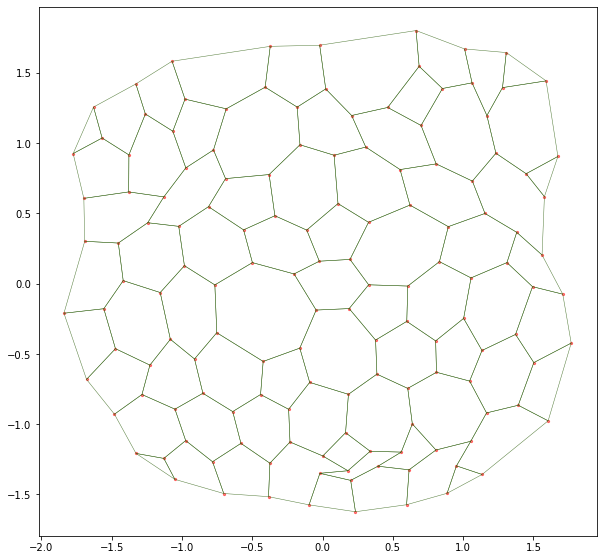

In [36]:
draw_specs = tyssue.config.draw.sheet_spec()

draw_specs['vert']['visible'] = True

draw_specs['vert']['color'] = "red"
draw_specs['vert']['alpha'] = 0.5
draw_specs['vert']['s'] = 5
coords = ['x', 'y']
fig, ax = sheet_view(cellmap_original, coords, **draw_specs)
fig.set_size_inches((10, 10))

In [40]:
new_verts = np.empty((0, 3))
for numEdge in range(len(cellmap_original.edge_df)):
    currentEdge = cellmap_original.edge_df.loc[numEdge];
    if currentEdge['length']>0.7:
        new_vert = add_vert(cellmap_original, numEdge)
        new_verts = np.append(new_verts, [new_vert])

In [41]:
new_verts

array([139, 385, None, 140, 386, None], dtype=object)

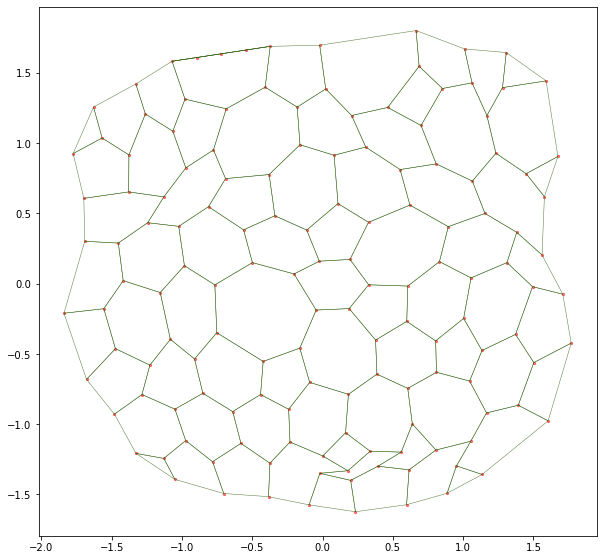

In [42]:
draw_specs = tyssue.config.draw.sheet_spec()

draw_specs['vert']['visible'] = True

draw_specs['vert']['color'] = "red"
draw_specs['vert']['alpha'] = 0.5
draw_specs['vert']['s'] = 5
coords = ['x', 'y']
fig, ax = sheet_view(cellmap_original, coords, **draw_specs)
fig.set_size_inches((10, 10))

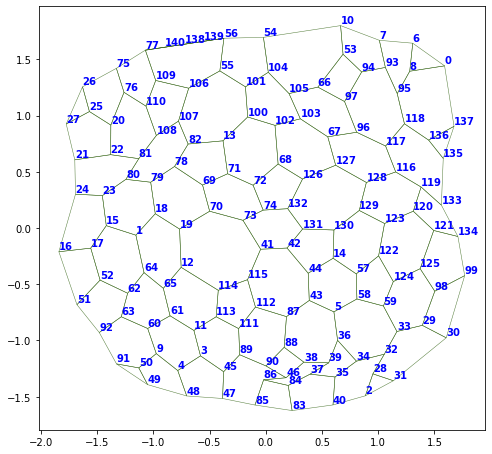

In [63]:
fig, ax = sheet_view(cellmap_original)
fig.set_size_inches(8, 8)

for vert, data in cellmap_original.vert_df.iterrows():
    ax.text(data.x, data.y+0.02, vert, weight="bold", color="blue")

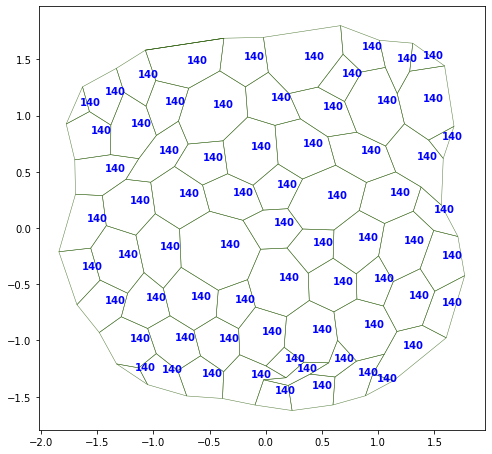

In [62]:
fig, ax = sheet_view(cellmap_original)
fig.set_size_inches(8, 8)

for face, data in cellmap_original.face_df.iterrows():
    ax.text(data.x, data.y+0.02, vert, weight="bold", color="blue")

In [47]:
cellmap_original.vert_df

,y,is_active,x,rank,viscosity
0,1.442318,1,1.590479,3,1
1,-0.063601,1,-1.154923,3,1
2,-1.491905,1,0.886045,3,1
3,-1.136721,1,-0.580470,3,1
4,-1.267261,1,-0.782710,3,1
...,...,...,...,...,...
136,0.781819,1,1.448645,3,1
137,0.904466,1,1.674403,3,1
138,1.634922,1,-0.721352,3,1
139,1.661427,1,-0.546713,3,1


In [60]:
vertex1 = cellmap_original.vert_df.loc[139] 
vertex2 = cellmap_original.vert_df.loc[106] 

new_edge = {
    "srce": vertex1,
    "trgt": vertex2,
    "face": 140,  # Assuming the edge is part of the first face
}

# Append the new edge to the edge data frame
cellmap_original.edge_df = cellmap_original.edge_df.append(new_edge, ignore_index=True)

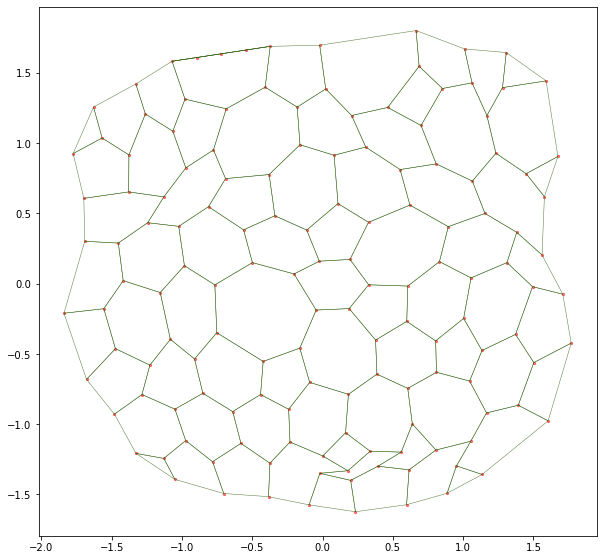

In [61]:
draw_specs = tyssue.config.draw.sheet_spec()

draw_specs['vert']['visible'] = True

draw_specs['vert']['color'] = "red"
draw_specs['vert']['alpha'] = 0.5
draw_specs['vert']['s'] = 5
coords = ['x', 'y']
fig, ax = sheet_view(cellmap_original, coords, **draw_specs)
fig.set_size_inches((10, 10))

In [10]:
import logging
import warnings

import numpy as np
import pandas as pd

from tyssue.topology.base_topology import add_vert, close_face, collapse_edge, remove_face
from tyssue.topology.base_topology import split_vert as base_split_vert

True


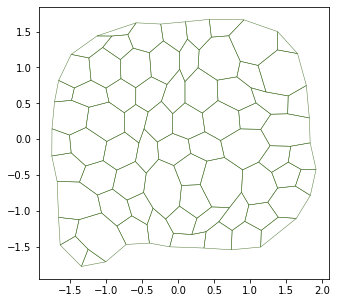

In [62]:
daughter = cell_division(cellmap_original, 22, geom_original, angle=np.pi/2)
monolayer.cell_df.loc[[mother, daughter], 'prefered_area'] /= 2

solver = QSSolver()
res = solver.find_energy_min(cellmap_original, geom_original, model_original)
print(res['success'])

fig, ax = sheet_view(cellmap_original)
fig.set_size_inches(12, 5)

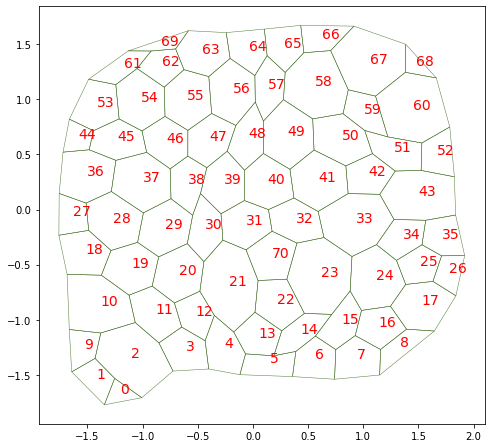

In [63]:
fig, ax = sheet_view(cellmap_original)
fig.set_size_inches(8, 8)

for face, data in cellmap_original.face_df.iterrows():
    ax.text(data.x, data.y, face, fontsize=14, color="r")

In [70]:
cellmap_original.

AttributeError: 'Sheet' object has no attribute 'sheet'